# Imports

In [22]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Dataset

In [23]:
data = CSV.read("./data.csv")

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.562,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


In [24]:
describe(data)

,variable,mean,min,median,max
,Symbol,Float64,Real,Float64,Real
1,Mean of the integrated profile,111.08,5.8125,115.078,192.617
2,Standard deviation of the integrated profile,46.5495,24.772,46.9475,98.7789
3,Excess kurtosis of the integrated profile,0.477857,-1.87601,0.22324,8.06952
4,Skewness of the integrated profile,1.77028,-1.79189,0.19871,68.1016
5,Mean of the DM-SNR curve,12.6144,0.213211,2.80184,223.392
6,Standard deviation of the DM-SNR curve,26.3265,7.37043,18.4613,110.642
7,Excess kurtosis of the DM-SNR curve,8.30356,-3.13927,8.43351,34.5398
8,Skewness of the DM-SNR curve,104.858,-1.97698,83.0646,1191.0
9,target_class,0.0915745,0,0.0,1


Look at class labels to see if dataset is imbalanced

In [25]:
label_counts = countmap(data[:(target_class)])

Dict{Int64,Int64} with 2 entries:
  0 => 16259
  1 => 1639

In [26]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.908425522404738
 0.09157447759526204

Get data ready for training

In [27]:
coerce!(data, :target_class=>Multiclass)
schema(data)

┌───────────────────────────────────────────────┬────────────────────────────────┬───────────────┐
│ _.names                                       │ _.types                        │ _.scitypes    │
├───────────────────────────────────────────────┼────────────────────────────────┼───────────────┤
│  Mean of the integrated profile               │ Float64                        │ Continuous    │
│  Standard deviation of the integrated profile │ Float64                        │ Continuous    │
│  Excess kurtosis of the integrated profile    │ Float64                        │ Continuous    │
│  Skewness of the integrated profile           │ Float64                        │ Continuous    │
│  Mean of the DM-SNR curve                     │ Float64                        │ Continuous    │
│  Standard deviation of the DM-SNR curve       │ Float64                        │ Continuous    │
│  Excess kurtosis of the DM-SNR curve          │ Float64                        │ Continuous    │
│  Skewnes

In [28]:
y, X = unpack(data, ==(:target_class), colname->true)

(CategoricalValue{Int64,UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17898×8 DataFrame. Omitted printing of 7 columns
│ Row   │  Mean of the integrated profile │
│       │ Float64                         │
├───────┼─────────────────────────────────┤
│ 1     │ 140.562                         │
│ 2     │ 102.508                         │
│ 3     │ 103.016                         │
│ 4     │ 136.75                          │
│ 5     │ 88.7266                         │
│ 6     │ 93.5703                         │
│ 7     │ 119.484                         │
│ 8     │ 130.383                         │
│ 9     │ 107.25                          │
│ 10    │ 107.258                         │
⋮
│ 17888 │ 121.375                         │
│ 17889 │ 98.7266                         │
│ 17890 │ 126.625                         │
│ 17891 │ 143.672                         │
│ 17892 │ 118.484                         │
│ 17893 │ 96.0                            │
│ 17894 │ 136.43 

Partition train and test data accoring to class labels

In [29]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:target_class])) # gives 70:30 split

([2859, 3242, 436, 12919, 3279, 17651, 16341, 14975, 16060, 730  …  805, 13608, 9896, 11042, 13883, 3467, 112, 9612, 2792, 261], [1078, 16815, 4553, 12452, 10187, 17806, 8156, 16807, 2688, 1554  …  4126, 15656, 16102, 15077, 13659, 13276, 13241, 8204, 5417, 415])

In [30]:
train_counts = countmap(data[train,:target_class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.9084450830140486
 0.09155491698595147

In [31]:
test_counts = countmap(data[test,:target_class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.9083798882681564
 0.09162011173184358

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [32]:
models(matching(X,y))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [33]:
@load AdaBoostClassifier verbosity=2

import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔


┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/5DFoi/src/loading.jl:70
┌ Warning: New model type being bound to `AdaBoostClassifier2` to avoid conflict with an existing name. 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/5DFoi/src/loading.jl:78


AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 50,
    learning_rate = 1.0,
    algorithm = "SAMME.R",
    random_state = nothing) @564

### Boosting
* Implement or steal a boosted version of your decision trees. 
* As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

**Chooses the hardest examples** talk about in write-up

In [34]:
boost_model = AdaBoostClassifier()

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 50,
    learning_rate = 1.0,
    algorithm = "SAMME.R",
    random_state = nothing) @941

In [35]:
boost_mach = machine(boost_model, X, y)

Machine{AdaBoostClassifier} @362 trained 0 times.
  args: 
    1:	Source @446 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @923 ⏎ `AbstractArray{Multiclass{2},1}`


In [36]:
fit!(boost_mach, rows=train, verbosity=2)

┌ Info: Training Machine{AdaBoostClassifier} @362.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Machine{AdaBoostClassifier} @362 trained 1 time.
  args: 
    1:	Source @446 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @923 ⏎ `AbstractArray{Multiclass{2},1}`


In [37]:
boost_acc = evaluate!(boost_mach, resampling=CV(shuffle=true), measure=[cross_entropy, acc], 
                      verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 0.593         │ [0.602, 0.602, 0.601, 0.602, 0.599, 0.551] │
│ acc           │ 0.978         │ [0.981, 0.977, 0.984, 0.978, 0.977, 0.971] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[0.665, 0.422, ..., 0.627], [0.626, 0.602, ..., 0.668], [0.596, 0.616, ..., 0.575], [0.622, 0.639, ..., 0.624], [0.639, 0.622, ..., 0.654], [0.621, 0.517, ..., 0.653]], missing]


In [38]:
# evaluate!(boost_mach, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [39]:
fitted_params(boost_mach);

### GridSearch 
number of estimators vs learning rate

In [40]:
param1 = :learning_rate
param2 = :n_estimators

r1 = range(boost_model, param1, lower=0.001, upper=10, scale=:log10)
r2 = range(boost_model, param2, lower=1, upper=100, scale=:log10)

MLJBase.NumericRange(Int64, :n_estimators, ... )

In [41]:
self_tuning_boost_model = TunedModel(model=boost_model,
                                    tuning=Grid(),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = AdaBoostClassifier(
            base_estimator = nothing,
            n_estimators = 50,
            learning_rate = 1.0,
            algorithm = "SAMME.R",
            random_state = nothing),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Float64,…} @191, NumericRange{Int64,…} @593],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @769

In [42]:
self_tuning_boost = machine(self_tuning_boost_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @724 trained 0 times.
  args: 
    1:	Source @059 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @587 ⏎ `AbstractArray{Multiclass{2},1}`


In [43]:
z = fit!(self_tuning_boost, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @724.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/nuvTc/src/tuned_models.jl:501
Evaluating over 100 metamodels: 100%[=========================] Time: 0:02:19


Machine{ProbabilisticTunedModel{Grid,…}} @724 trained 1 time.
  args: 
    1:	Source @059 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @587 ⏎ `AbstractArray{Multiclass{2},1}`


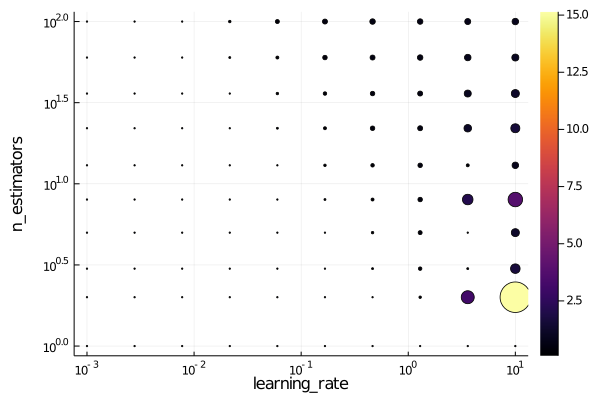

In [44]:
plot(self_tuning_boost)

In [45]:
best = fitted_params(self_tuning_boost)
best.best_model

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 5,
    learning_rate = 0.05994842503189409,
    algorithm = "SAMME.R",
    random_state = nothing) @620

In [46]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.09942

In [ ]:
best_n = best.best_model.n_estimators

In [47]:
best_lr = best.best_model.learning_rate

0.05994842503189409

In [48]:
fn = "Figures/LearningCurve_Boost_nestimators:$(best_n)_lr:$(best_lr)_loss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curves

In [49]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc, step=50)

(d, train_metric, valid_metric) = (10, 1.0, 0.8918595371109338)
(d, train_metric, valid_metric) = (15, 1.0, 0.8994413407821229)
(d, train_metric, valid_metric) = (20, 1.0, 0.8994413407821229)
(d, train_metric, valid_metric) = (25, 1.0, 0.8998403830806065)
(d, train_metric, valid_metric) = (30, 1.0, 0.9648842777334398)
(d, train_metric, valid_metric) = (35, 1.0, 0.9545091779728652)
(d, train_metric, valid_metric) = (40, 1.0, 0.9545091779728652)
(d, train_metric, valid_metric) = (45, 1.0, 0.9018355945730248)
(d, train_metric, valid_metric) = (50, 1.0, 0.903830806065443)
(d, train_metric, valid_metric) = (55, 1.0, 0.9421388667198723)
(d, train_metric, valid_metric) = (60, 1.0, 0.9421388667198723)
(d, train_metric, valid_metric) = (65, 1.0, 0.9537110933758979)
(d, train_metric, valid_metric) = (70, 1.0, 0.9505187549880287)
(d, train_metric, valid_metric) = (75, 1.0, 0.9505187549880287)
(d, train_metric, valid_metric) = (80, 1.0, 0.9421388667198723)
(d, train_metric, valid_metric) = (85, 1.

(d, train_metric, valid_metric) = (560, 0.9767857142857143, 0.9772545889864326)
(d, train_metric, valid_metric) = (565, 0.9769911504424779, 0.9772545889864326)
(d, train_metric, valid_metric) = (570, 0.9771929824561404, 0.9772545889864326)
(d, train_metric, valid_metric) = (575, 0.9773913043478261, 0.9772545889864326)
(d, train_metric, valid_metric) = (580, 0.9775862068965517, 0.9772545889864326)
(d, train_metric, valid_metric) = (585, 0.9777777777777777, 0.9772545889864326)
(d, train_metric, valid_metric) = (590, 0.9779661016949153, 0.9772545889864326)
(d, train_metric, valid_metric) = (595, 0.9781512605042016, 0.9772545889864326)
(d, train_metric, valid_metric) = (600, 0.9783333333333334, 0.9772545889864326)
(d, train_metric, valid_metric) = (605, 0.9768595041322314, 0.9772545889864326)
(d, train_metric, valid_metric) = (610, 0.9770491803278688, 0.9772545889864326)
(d, train_metric, valid_metric) = (615, 0.9772357723577236, 0.9772545889864326)
(d, train_metric, valid_metric) = (620, 

(d, train_metric, valid_metric) = (1110, 0.981081081081081, 0.9808459696727854)
(d, train_metric, valid_metric) = (1115, 0.9811659192825112, 0.9808459696727854)
(d, train_metric, valid_metric) = (1120, 0.98125, 0.9808459696727854)
(d, train_metric, valid_metric) = (1125, 0.9813333333333333, 0.9808459696727854)
(d, train_metric, valid_metric) = (1130, 0.9814159292035398, 0.9808459696727854)
(d, train_metric, valid_metric) = (1135, 0.9814977973568282, 0.9808459696727854)
(d, train_metric, valid_metric) = (1140, 0.980701754385965, 0.9808459696727854)
(d, train_metric, valid_metric) = (1145, 0.9807860262008734, 0.9808459696727854)
(d, train_metric, valid_metric) = (1150, 0.9808695652173913, 0.9808459696727854)
(d, train_metric, valid_metric) = (1155, 0.9809523809523809, 0.9808459696727854)
(d, train_metric, valid_metric) = (1160, 0.9810344827586207, 0.9808459696727854)
(d, train_metric, valid_metric) = (1165, 0.9811158798283262, 0.9808459696727854)
(d, train_metric, valid_metric) = (1170, 

(d, train_metric, valid_metric) = (1625, 0.9772307692307692, 0.9796488427773344)
(d, train_metric, valid_metric) = (1630, 0.9773006134969325, 0.9796488427773344)
(d, train_metric, valid_metric) = (1635, 0.9773700305810398, 0.9796488427773344)
(d, train_metric, valid_metric) = (1640, 0.9774390243902439, 0.9796488427773344)
(d, train_metric, valid_metric) = (1645, 0.9775075987841946, 0.9796488427773344)
(d, train_metric, valid_metric) = (1650, 0.9775757575757575, 0.9796488427773344)
(d, train_metric, valid_metric) = (1655, 0.9776435045317221, 0.9796488427773344)
(d, train_metric, valid_metric) = (1660, 0.977710843373494, 0.9796488427773344)
(d, train_metric, valid_metric) = (1665, 0.9777777777777777, 0.9796488427773344)
(d, train_metric, valid_metric) = (1670, 0.9778443113772455, 0.9796488427773344)
(d, train_metric, valid_metric) = (1675, 0.9779104477611941, 0.9796488427773344)
(d, train_metric, valid_metric) = (1680, 0.9779761904761904, 0.9796488427773344)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (2135, 0.9798594847775176, 0.9796488427773344)
(d, train_metric, valid_metric) = (2140, 0.9799065420560747, 0.9796488427773344)
(d, train_metric, valid_metric) = (2145, 0.9799533799533799, 0.9796488427773344)
(d, train_metric, valid_metric) = (2150, 0.98, 0.9796488427773344)
(d, train_metric, valid_metric) = (2155, 0.980046403712297, 0.9796488427773344)
(d, train_metric, valid_metric) = (2160, 0.9800925925925926, 0.9796488427773344)
(d, train_metric, valid_metric) = (2165, 0.979676674364896, 0.9800478850758181)
(d, train_metric, valid_metric) = (2170, 0.9797235023041475, 0.9800478850758181)
(d, train_metric, valid_metric) = (2175, 0.9797701149425287, 0.9800478850758181)
(d, train_metric, valid_metric) = (2180, 0.9798165137614679, 0.9800478850758181)
(d, train_metric, valid_metric) = (2185, 0.9794050343249427, 0.9800478850758181)
(d, train_metric, valid_metric) = (2190, 0.9794520547945206, 0.9800478850758181)
(d, train_metric, valid_metric) = (2195, 0.9

(d, train_metric, valid_metric) = (2655, 0.9792843691148776, 0.9804469273743017)
(d, train_metric, valid_metric) = (2660, 0.9793233082706767, 0.9804469273743017)
(d, train_metric, valid_metric) = (2665, 0.9793621013133208, 0.9804469273743017)
(d, train_metric, valid_metric) = (2670, 0.9790262172284644, 0.9804469273743017)
(d, train_metric, valid_metric) = (2675, 0.9790654205607476, 0.9804469273743017)
(d, train_metric, valid_metric) = (2680, 0.9791044776119403, 0.9804469273743017)
(d, train_metric, valid_metric) = (2685, 0.9787709497206704, 0.9804469273743017)
(d, train_metric, valid_metric) = (2690, 0.978810408921933, 0.9804469273743017)
(d, train_metric, valid_metric) = (2695, 0.9788497217068646, 0.9804469273743017)
(d, train_metric, valid_metric) = (2700, 0.9788888888888889, 0.9804469273743017)
(d, train_metric, valid_metric) = (2705, 0.9789279112754159, 0.9804469273743017)
(d, train_metric, valid_metric) = (2710, 0.9789667896678966, 0.9804469273743017)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (3175, 0.9792125984251968, 0.9804469273743017)
(d, train_metric, valid_metric) = (3180, 0.9789308176100628, 0.9804469273743017)
(d, train_metric, valid_metric) = (3185, 0.9789638932496075, 0.9804469273743017)
(d, train_metric, valid_metric) = (3190, 0.9789968652037617, 0.9804469273743017)
(d, train_metric, valid_metric) = (3195, 0.9790297339593115, 0.9804469273743017)
(d, train_metric, valid_metric) = (3200, 0.9790625, 0.9804469273743017)
(d, train_metric, valid_metric) = (3205, 0.9790951638065523, 0.9804469273743017)
(d, train_metric, valid_metric) = (3210, 0.9791277258566978, 0.9804469273743017)
(d, train_metric, valid_metric) = (3215, 0.9791601866251944, 0.9804469273743017)
(d, train_metric, valid_metric) = (3220, 0.9788819875776398, 0.9804469273743017)
(d, train_metric, valid_metric) = (3225, 0.9789147286821706, 0.9804469273743017)
(d, train_metric, valid_metric) = (3230, 0.9789473684210527, 0.9804469273743017)
(d, train_metric, valid_metric) = (32

(d, train_metric, valid_metric) = (3700, 0.9789189189189189, 0.9796488427773344)
(d, train_metric, valid_metric) = (3705, 0.9784075573549258, 0.9804469273743017)
(d, train_metric, valid_metric) = (3710, 0.9784366576819407, 0.9804469273743017)
(d, train_metric, valid_metric) = (3715, 0.9784656796769852, 0.9804469273743017)
(d, train_metric, valid_metric) = (3720, 0.978494623655914, 0.9804469273743017)
(d, train_metric, valid_metric) = (3725, 0.978523489932886, 0.9804469273743017)
(d, train_metric, valid_metric) = (3730, 0.9782841823056301, 0.9804469273743017)
(d, train_metric, valid_metric) = (3735, 0.9783132530120482, 0.9804469273743017)
(d, train_metric, valid_metric) = (3740, 0.9783422459893049, 0.9804469273743017)
(d, train_metric, valid_metric) = (3745, 0.9783711615487316, 0.9804469273743017)
(d, train_metric, valid_metric) = (3750, 0.9784, 0.9804469273743017)
(d, train_metric, valid_metric) = (3755, 0.9784287616511318, 0.9804469273743017)
(d, train_metric, valid_metric) = (3760, 0

(d, train_metric, valid_metric) = (4220, 0.978436018957346, 0.9800478850758181)
(d, train_metric, valid_metric) = (4225, 0.9784615384615385, 0.9800478850758181)
(d, train_metric, valid_metric) = (4230, 0.9784869976359338, 0.9800478850758181)
(d, train_metric, valid_metric) = (4235, 0.9785123966942149, 0.9800478850758181)
(d, train_metric, valid_metric) = (4240, 0.9785377358490566, 0.9800478850758181)
(d, train_metric, valid_metric) = (4245, 0.978563015312132, 0.9800478850758181)
(d, train_metric, valid_metric) = (4250, 0.9785882352941176, 0.9800478850758181)
(d, train_metric, valid_metric) = (4255, 0.9786133960047003, 0.9800478850758181)
(d, train_metric, valid_metric) = (4260, 0.9786384976525822, 0.9800478850758181)
(d, train_metric, valid_metric) = (4265, 0.9791324736225088, 0.9796488427773344)
(d, train_metric, valid_metric) = (4270, 0.9791569086651054, 0.9796488427773344)
(d, train_metric, valid_metric) = (4275, 0.9791812865497076, 0.9796488427773344)
(d, train_metric, valid_metric

(d, train_metric, valid_metric) = (4735, 0.978247096092925, 0.9796488427773344)
(d, train_metric, valid_metric) = (4740, 0.9782700421940929, 0.9796488427773344)
(d, train_metric, valid_metric) = (4745, 0.9782929399367756, 0.9796488427773344)
(d, train_metric, valid_metric) = (4750, 0.9783157894736842, 0.9796488427773344)
(d, train_metric, valid_metric) = (4755, 0.9783385909568875, 0.9796488427773344)
(d, train_metric, valid_metric) = (4760, 0.9783613445378151, 0.9796488427773344)
(d, train_metric, valid_metric) = (4765, 0.9783840503672613, 0.9796488427773344)
(d, train_metric, valid_metric) = (4770, 0.9784067085953878, 0.9796488427773344)
(d, train_metric, valid_metric) = (4775, 0.9784293193717277, 0.9796488427773344)
(d, train_metric, valid_metric) = (4780, 0.9784518828451882, 0.9796488427773344)
(d, train_metric, valid_metric) = (4785, 0.9784743991640543, 0.9796488427773344)
(d, train_metric, valid_metric) = (4790, 0.9784968684759916, 0.9796488427773344)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (5250, 0.9777142857142858, 0.9796488427773344)
(d, train_metric, valid_metric) = (5255, 0.9775451950523311, 0.9796488427773344)
(d, train_metric, valid_metric) = (5260, 0.9773764258555133, 0.9796488427773344)
(d, train_metric, valid_metric) = (5265, 0.977397910731244, 0.9796488427773344)
(d, train_metric, valid_metric) = (5270, 0.9774193548387097, 0.9796488427773344)
(d, train_metric, valid_metric) = (5275, 0.9774407582938388, 0.9796488427773344)
(d, train_metric, valid_metric) = (5280, 0.9774621212121212, 0.9796488427773344)
(d, train_metric, valid_metric) = (5285, 0.9774834437086093, 0.9796488427773344)
(d, train_metric, valid_metric) = (5290, 0.9775047258979206, 0.9796488427773344)
(d, train_metric, valid_metric) = (5295, 0.9775259678942398, 0.9796488427773344)
(d, train_metric, valid_metric) = (5300, 0.9775471698113207, 0.9796488427773344)
(d, train_metric, valid_metric) = (5305, 0.9775683317624883, 0.9796488427773344)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (5760, 0.9776041666666667, 0.9796488427773344)
(d, train_metric, valid_metric) = (5765, 0.977623590633131, 0.9796488427773344)
(d, train_metric, valid_metric) = (5770, 0.9776429809358752, 0.9796488427773344)
(d, train_metric, valid_metric) = (5775, 0.9776623376623377, 0.9796488427773344)
(d, train_metric, valid_metric) = (5780, 0.9773356401384083, 0.9796488427773344)
(d, train_metric, valid_metric) = (5785, 0.9773552290406223, 0.9796488427773344)
(d, train_metric, valid_metric) = (5790, 0.9773747841105354, 0.9796488427773344)
(d, train_metric, valid_metric) = (5795, 0.9773943054357205, 0.9796488427773344)
(d, train_metric, valid_metric) = (5800, 0.9772413793103448, 0.9796488427773344)
(d, train_metric, valid_metric) = (5805, 0.9772609819121447, 0.9796488427773344)
(d, train_metric, valid_metric) = (5810, 0.9772805507745267, 0.9796488427773344)
(d, train_metric, valid_metric) = (5815, 0.9773000859845228, 0.9796488427773344)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (6270, 0.9781499202551834, 0.9796488427773344)
(d, train_metric, valid_metric) = (6275, 0.9781673306772909, 0.9796488427773344)
(d, train_metric, valid_metric) = (6280, 0.9781847133757962, 0.9796488427773344)
(d, train_metric, valid_metric) = (6285, 0.9782020684168655, 0.9796488427773344)
(d, train_metric, valid_metric) = (6290, 0.978060413354531, 0.9796488427773344)
(d, train_metric, valid_metric) = (6295, 0.9780778395552026, 0.9796488427773344)
(d, train_metric, valid_metric) = (6300, 0.9780952380952381, 0.9796488427773344)
(d, train_metric, valid_metric) = (6305, 0.9779540047581284, 0.9796488427773344)
(d, train_metric, valid_metric) = (6310, 0.9779714738510301, 0.9796488427773344)
(d, train_metric, valid_metric) = (6315, 0.9778305621536025, 0.9796488427773344)
(d, train_metric, valid_metric) = (6320, 0.9778481012658228, 0.9796488427773344)
(d, train_metric, valid_metric) = (6325, 0.9778656126482214, 0.9796488427773344)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (6775, 0.9775645756457565, 0.9792498004788508)
(d, train_metric, valid_metric) = (6780, 0.9775811209439528, 0.9792498004788508)
(d, train_metric, valid_metric) = (6785, 0.9775976418570376, 0.9792498004788508)
(d, train_metric, valid_metric) = (6790, 0.9774668630338733, 0.9792498004788508)
(d, train_metric, valid_metric) = (6795, 0.9774834437086093, 0.9792498004788508)
(d, train_metric, valid_metric) = (6800, 0.9775, 0.9792498004788508)
(d, train_metric, valid_metric) = (6805, 0.9775165319617928, 0.9792498004788508)
(d, train_metric, valid_metric) = (6810, 0.9773861967694567, 0.9792498004788508)
(d, train_metric, valid_metric) = (6815, 0.9774027879677183, 0.9792498004788508)
(d, train_metric, valid_metric) = (6820, 0.9774193548387097, 0.9792498004788508)
(d, train_metric, valid_metric) = (6825, 0.9774358974358974, 0.9792498004788508)
(d, train_metric, valid_metric) = (6830, 0.9774524158125915, 0.9792498004788508)
(d, train_metric, valid_metric) = (6835,

(d, train_metric, valid_metric) = (7285, 0.9772134522992451, 0.9792498004788508)
(d, train_metric, valid_metric) = (7290, 0.9772290809327846, 0.9792498004788508)
(d, train_metric, valid_metric) = (7295, 0.9772446881425634, 0.9792498004788508)
(d, train_metric, valid_metric) = (7300, 0.9771232876712329, 0.9792498004788508)
(d, train_metric, valid_metric) = (7305, 0.977138945927447, 0.9792498004788508)
(d, train_metric, valid_metric) = (7310, 0.9771545827633379, 0.9792498004788508)
(d, train_metric, valid_metric) = (7315, 0.9771701982228298, 0.9792498004788508)
(d, train_metric, valid_metric) = (7320, 0.9771857923497268, 0.9792498004788508)
(d, train_metric, valid_metric) = (7325, 0.9772013651877133, 0.9792498004788508)
(d, train_metric, valid_metric) = (7330, 0.9772169167803547, 0.9792498004788508)
(d, train_metric, valid_metric) = (7335, 0.9772324471710975, 0.9792498004788508)
(d, train_metric, valid_metric) = (7340, 0.9772479564032698, 0.9792498004788508)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (7800, 0.9776923076923076, 0.9792498004788508)
(d, train_metric, valid_metric) = (7805, 0.977706598334401, 0.9792498004788508)
(d, train_metric, valid_metric) = (7810, 0.9775928297055058, 0.9792498004788508)
(d, train_metric, valid_metric) = (7815, 0.9774792066538708, 0.9792498004788508)
(d, train_metric, valid_metric) = (7820, 0.9774936061381074, 0.9792498004788508)
(d, train_metric, valid_metric) = (7825, 0.9775079872204473, 0.9792498004788508)
(d, train_metric, valid_metric) = (7830, 0.9772669220945083, 0.9792498004788508)
(d, train_metric, valid_metric) = (7835, 0.9772814294830887, 0.9792498004788508)
(d, train_metric, valid_metric) = (7840, 0.977295918367347, 0.9792498004788508)
(d, train_metric, valid_metric) = (7845, 0.9773103887826641, 0.9792498004788508)
(d, train_metric, valid_metric) = (7850, 0.9773248407643312, 0.9792498004788508)
(d, train_metric, valid_metric) = (7855, 0.9773392743475493, 0.9792498004788508)
(d, train_metric, valid_metric

(d, train_metric, valid_metric) = (8305, 0.9768813967489464, 0.9792498004788508)
(d, train_metric, valid_metric) = (8310, 0.9768953068592058, 0.9792498004788508)
(d, train_metric, valid_metric) = (8315, 0.9769092002405292, 0.9792498004788508)
(d, train_metric, valid_metric) = (8320, 0.9769230769230769, 0.9792498004788508)
(d, train_metric, valid_metric) = (8325, 0.976936936936937, 0.9792498004788508)
(d, train_metric, valid_metric) = (8330, 0.9769507803121249, 0.9792498004788508)
(d, train_metric, valid_metric) = (8335, 0.9769646070785842, 0.9792498004788508)
(d, train_metric, valid_metric) = (8340, 0.9769784172661871, 0.9792498004788508)
(d, train_metric, valid_metric) = (8345, 0.9769922109047334, 0.9792498004788508)
(d, train_metric, valid_metric) = (8350, 0.9770059880239521, 0.9792498004788508)
(d, train_metric, valid_metric) = (8355, 0.9770197486535009, 0.9792498004788508)
(d, train_metric, valid_metric) = (8360, 0.9767942583732058, 0.9792498004788508)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (8815, 0.9768576290414067, 0.9792498004788508)
(d, train_metric, valid_metric) = (8820, 0.9768707482993197, 0.9792498004788508)
(d, train_metric, valid_metric) = (8825, 0.9768838526912181, 0.9792498004788508)
(d, train_metric, valid_metric) = (8830, 0.9768969422423556, 0.9792498004788508)
(d, train_metric, valid_metric) = (8835, 0.9769100169779287, 0.9792498004788508)
(d, train_metric, valid_metric) = (8840, 0.9769230769230769, 0.9792498004788508)
(d, train_metric, valid_metric) = (8845, 0.9769361221028829, 0.9792498004788508)
(d, train_metric, valid_metric) = (8850, 0.9769491525423729, 0.9792498004788508)
(d, train_metric, valid_metric) = (8855, 0.976962168266516, 0.9792498004788508)
(d, train_metric, valid_metric) = (8860, 0.9769751693002258, 0.9792498004788508)
(d, train_metric, valid_metric) = (8865, 0.9769881556683587, 0.9792498004788508)
(d, train_metric, valid_metric) = (8870, 0.9770011273957159, 0.9792498004788508)
(d, train_metric, valid_metri

(d, train_metric, valid_metric) = (9325, 0.9768364611260053, 0.9800478850758181)
(d, train_metric, valid_metric) = (9330, 0.9767416934619507, 0.9800478850758181)
(d, train_metric, valid_metric) = (9335, 0.9767541510444564, 0.9800478850758181)
(d, train_metric, valid_metric) = (9340, 0.9767665952890793, 0.9800478850758181)
(d, train_metric, valid_metric) = (9345, 0.9767790262172285, 0.9800478850758181)
(d, train_metric, valid_metric) = (9350, 0.9767914438502674, 0.9800478850758181)
(d, train_metric, valid_metric) = (9355, 0.9768038482095136, 0.9800478850758181)
(d, train_metric, valid_metric) = (9360, 0.9768162393162393, 0.9800478850758181)
(d, train_metric, valid_metric) = (9365, 0.9768286171916711, 0.9800478850758181)
(d, train_metric, valid_metric) = (9370, 0.9768409818569904, 0.9800478850758181)
(d, train_metric, valid_metric) = (9375, 0.9767466666666667, 0.9800478850758181)
(d, train_metric, valid_metric) = (9380, 0.9767590618336887, 0.9800478850758181)
(d, train_metric, valid_metr

(d, train_metric, valid_metric) = (9835, 0.9773258769700051, 0.9800478850758181)
(d, train_metric, valid_metric) = (9840, 0.9773373983739837, 0.9800478850758181)
(d, train_metric, valid_metric) = (9845, 0.9773489080751651, 0.9800478850758181)
(d, train_metric, valid_metric) = (9850, 0.977258883248731, 0.9800478850758181)
(d, train_metric, valid_metric) = (9855, 0.9772704211060376, 0.9800478850758181)
(d, train_metric, valid_metric) = (9860, 0.9772819472616633, 0.9800478850758181)
(d, train_metric, valid_metric) = (9865, 0.9772934617334009, 0.9800478850758181)
(d, train_metric, valid_metric) = (9870, 0.9773049645390071, 0.9800478850758181)
(d, train_metric, valid_metric) = (9875, 0.9772151898734177, 0.9800478850758181)
(d, train_metric, valid_metric) = (9880, 0.9771255060728745, 0.9800478850758181)
(d, train_metric, valid_metric) = (9885, 0.977137076378351, 0.9800478850758181)
(d, train_metric, valid_metric) = (9890, 0.9771486349848332, 0.9800478850758181)
(d, train_metric, valid_metric

(10:5:10020, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.9772431077694236, 0.9772545090180361, 0.9772658988482724, 0.9772772772772773, 0.9772886443221611, 0.9773, 0.9773113443278361, 0.9773226773226773, 0.9773339990014978, 0.9773453093812375], Any[0.8918595371109338, 0.8994413407821229, 0.8994413407821229, 0.8998403830806065, 0.9648842777334398, 0.9545091779728652, 0.9545091779728652, 0.9018355945730248, 0.903830806065443, 0.9421388667198723  …  0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181, 0.9800478850758181])

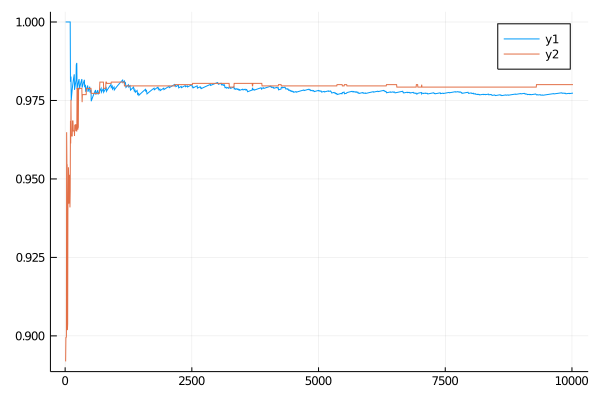

In [50]:
plot(data_schedule, training_losses, label="Training Loss")
plot!(data_schedule, valid_losses, label="Validation Loss")

# Final Results

In [51]:
final_boost_model = best.best_model

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 5,
    learning_rate = 0.05994842503189409,
    algorithm = "SAMME.R",
    random_state = nothing) @620

In [52]:
Final_Boost = machine(final_boost_model, X, y)

Machine{AdaBoostClassifier} @612 trained 0 times.
  args: 
    1:	Source @724 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @389 ⏎ `AbstractArray{Multiclass{2},1}`


In [53]:
fit!(Final_Boost, rows=train, verbosity=2)

┌ Info: Training Machine{AdaBoostClassifier} @612.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Machine{AdaBoostClassifier} @612 trained 1 time.
  args: 
    1:	Source @724 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @389 ⏎ `AbstractArray{Multiclass{2},1}`


In [54]:
ŷ2 = MLJ.predict(Final_Boost, X[test,:]);

In [55]:
cross_entropy(ŷ2, y[test]) |> mean

0.10363087465400607

In [56]:
acc(ŷ2, y[test])

0.9772811918063314

In [57]:
confusion_matrix(mode.(ŷ2), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4850     │     94      │
├─────────────┼─────────────┼─────────────┤
│      1      │     28      │     398     │
└─────────────┴─────────────┴─────────────┘
